In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image

In [2]:
black = (0, 0, 0)
white = (255, 255, 255)
yellow = (242, 230, 61)
blue = (0, 0, 255)
green = (0, 255, 0)
sky_blue = (159, 197, 232)
yellow = (255, 214, 0)
land_green = (56, 118, 29)

In [3]:
def make_canvas(color, width=0, height=0):
    pixels = [color] * (width * height)
    grid = np.empty(len(pixels), dtype='object')
    grid[:] = pixels
    grid = grid.reshape(height, width).tolist()
    return grid

In [4]:
def generate_image(grid, show_grid=False, show=False, save=False, outdir=None, filename=None):
    plt.imshow(grid)
    plt.gca().invert_yaxis()
    if show_grid:
        plt.grid(visible=True)
    else:
        plt.axis("off")
    if save:
        plt.savefig(f"{outdir}/{filename}")
    if show:
        plt.show()

In [5]:
def find_bounds(grid_dim, shape_dim, align=None):
    
    if align == "center":
        # Left and bottom bias
        start = (grid_dim / 2) - (shape_dim / 2)
    if align == "left" or align == "bottom":
        start = 0
    if align == "right" or align == "top":
        start = grid_dim - shape_dim
    
    end = start + shape_dim - 1
    return int(start), int(end)

In [6]:
def get_grid_dimensions(grid): 
    grid_width = len(grid[0])
    grid_height = len(grid)
    return grid_width, grid_height

In [7]:
def generate_show_map(raw_show_map, xbounds, ybounds, style=None, strategy=None):
    
    show_map = {}
    
    xleft, xright = xbounds
    ybottom, ytop = ybounds
    
    if strategy == "distance":
        # Get center coordinates (e.g. circle)
        xcenter = xright - ((xright - xleft) / 2)
        ycenter = ytop - ((ytop - ybottom) / 2)
    
    for yvalue in range(ybottom, ytop+1):
        show_map[yvalue] = {}
        
        if style == "outline":
            left_border = None
            right_border = None
        
        for xvalue in range(xleft, xright+1):
                
            if strategy == "distance":
                # Based on distance from center, determine whether to fill pixel or not
                xdistance = abs(xvalue - xcenter)
                ydistance = abs(yvalue - ycenter)
                show_value = raw_show_map[ydistance][xdistance]
            
            elif strategy == "shape_array":
                ycoord = yvalue - ybottom
                xcoord = xvalue - xleft
                show_value = bool(raw_show_map[ycoord][xcoord])
                
            else:
                show_value = True
                
            if style == "outline":
                
                if yvalue == ybottom or yvalue == ytop:
                    show_map[yvalue][xvalue] = show_value
                    continue
                
                if show_value is True:
                    if left_border is None:
                        left_border = xvalue
                    else:
                        right_border = xvalue
                
                show_map[yvalue][xvalue] = False
                        
            else:    
                show_map[yvalue][xvalue] = show_value
                
        if style == "outline":
            if yvalue != ybottom and yvalue != ytop:
                show_map[yvalue][left_border] = True
                show_map[yvalue][right_border] = True
            
    return show_map

In [8]:
# DEPRECATED!
def convert_show_map(raw_show_map, style=None):
    show_map = {}
    
    if style == "outline":
        for yvalue, curr_show_map in raw_show_map.items():
            print(yvalue, curr_show_values)
            true_indices = np.where(curr_show_values == 1)[0]
            print(true_indices)
            keep_true = [min(true_indices), max(true_indices)]
            new_show_values = [True if index in keep_true else False for index in range(0, len(curr_show_values))]
            show_map[yvalue] = new_show_values
            
    return show_map

In [9]:
def patch_outline(raw_show_map):
    print("TODO OUTLINE!")
    return raw_show_map

In [10]:
def make_shape(grid, style="fill", shape=None, shape_array=None, shape_width=0, shape_height=0, xalign=None, yalign=None, xoffset=0, yoffset=0):

    if shape is None:
        shape_width = len(shape_array[0])
        shape_height = len(shape_array)
        
    grid_width, grid_height = get_grid_dimensions(grid)
    xleft, xright = find_bounds(grid_width, shape_width, align=xalign)
    ybottom, ytop = find_bounds(grid_height, shape_height, align=yalign)
    
    xleft += xoffset
    xright += xoffset
    ybottom += yoffset
    ytop += yoffset
    
    if shape == "rectangle":
        show_map = generate_show_map({}, (xleft, xright), (ybottom, ytop), style=style)
    
    elif shape == "circle":
        raw_show_map = {}
        
        # TODO x vs y radius for ovals
        radius = shape_width / 2
        if shape_width % 2 == 0:
            xfactor = 0
        else:
            xfactor = 0.5
            
        if shape_height % 2 == 0:
            yfactor = 0
        else:
            yfactor = 0.5
            
        for ycount in range(0, int(shape_height/2)+1):
            raw_show_map[ycount] = {}
            for xcount in range(0, int(shape_width/2)+1):
                xedge = xcount + xfactor
                yedge = ycount + yfactor
                max_distance = (xedge**2 + yedge**2)**(1/2)
                if max_distance > (radius*1.01):
                    raw_show_map[ycount][xcount] = False
                else:
                    raw_show_map[ycount][xcount] = True
        
        show_map = generate_show_map(raw_show_map, (xleft, xright), (ybottom, ytop), style=style, strategy="distance")
    
    elif shape is None:
        show_map = generate_show_map(shape_array, (xleft, xright), (ybottom, ytop), style=style, strategy="shape_array")
    
    if style == "outline":
        show_map = patch_outline(show_map)
        
    return show_map

In [11]:
def draw(grid, show_map, color):
    # Change color values for relevant pixel coordinates
    for yvalue, yvalue_show_map in show_map.items():
        for xvalue, show_value in yvalue_show_map.items():
            
            if show_value is False:
                continue
                  
            try:
                grid[yvalue][xvalue] = color
            except IndexError:
                continue
            
    return grid

In [12]:
def calculate_euclidian_distance(coords1, coords2):
    x1, y1 = coords1
    x2, y2 = coords2
    return ((x2-x1)**2 + (y2-y1)**2)**(1/2)

In [13]:
def calculate_step_distance(coords1, coords2):
    x1, y1 = coords1
    x2, y2 = coords2
    xsteps = abs(x2-x1)
    ysteps = abs(y2-y1)
    return xsteps + ysteps

In [14]:
def get_start_coords(grid, xfinal=0, yfinal=0, start_coords=None, min_steps=0, max_steps=0):

    grid_width, grid_height = get_grid_dimensions(grid)
    
    initial_distance = max_steps + 1 # Just to make sure we enter the loop
    if start_coords is None:
        while initial_distance > max_steps or initial_distance < min_steps:
            xstart = random.randint(0, grid_width)
            ystart = random.randint(0, grid_height)
            initial_distance = calculate_step_distance((xstart, ystart), (xfinal, yfinal))
    else:
        xstart, ystart = start_coords
        initial_distance = calculate_step_distance((xstart, ystart), (xfinal, yfinal))
        if initial_distance > max_steps or initial_distance < min_steps:
            raise ValueError("you picked bad start coords dummy")
    
    return xstart, ystart

In [15]:
def calculate_xy_probs(xdelta, ydelta):
    if xdelta == 0:
        return 0, 1
    if ydelta == 0:
        return 1, 0
    
    delta_ratio = (abs(xdelta)+1) / (abs(ydelta)+1)
    # px + py = 1
    # delta_ratio(py) + py = 1
    py = 1 / (delta_ratio + 1)
    px = 1 - py
    return px, py

In [16]:
def take_step(curr, delta):
    if delta > 0:
        return curr - 1, delta - 1
    elif delta < 0:
        return curr + 1, delta + 1
    else:
        raise ValueError("you fucked up!")

In [17]:
def generate_pixel_sequence(grid, xfinal=0, yfinal=0, start_coords=None, min_steps=0, max_steps=0):
    
    coords_sequence = []
    xstart, ystart = get_start_coords(grid, xfinal=xfinal, yfinal=yfinal, start_coords=start_coords, min_steps=min_steps, max_steps=max_steps)
    
    xcurr, ycurr = xstart, ystart
    xdelta = xcurr - xfinal
    ydelta = ycurr - yfinal
    step_count = 0
    while (xcurr, ycurr) != (xfinal, yfinal):
        
        # Decide which direction to move in
        xprob, yprob = calculate_xy_probs(xdelta, ydelta)
        
        if random.random() < xprob:
            xcurr, xdelta = take_step(xcurr, xdelta)
        else:
            ycurr, ydelta = take_step(ycurr, ydelta)
            
        step_count += 1
        
        coords_sequence.append((xcurr, ycurr))
        
    return coords_sequence

In [78]:
def convert_sprite_to_array(image_filepath, bg_color=None, scale=None, method=None):
    """Convert an image file (so far just Aseprite PNG exports) into a show_map array
    
    TODO: implemenet exact method, scaling functionality"""
    
    image = Image.open(image_filepath)
    image_array = np.asarray(image)
    
    # TODO rename "boundaries"
    boundaries = [] # Each element is this list is a (Xmin, Xmax) tuple for a given Y value
    empty_rows = []
    ybottom, ytop, xmin, xmax = None, None, None, None
    for ycoord, color_values in enumerate(image_array):
        
        xleft, xright = None, None
        
        for xcoord, color_value in enumerate(color_values):
            
            if color_value != bg_color:
                
                # Within this row
                if xleft is None:
                    xleft = xcoord 
                else:
                    xright = xcoord
                    
                # Across entire image
                if xmin is None:
                    xmin = xcoord
                elif xcoord < xmin:
                    xmin = xleft
                
                if xmax is None:
                    xmax = xcoord
                elif xcoord > xmax:
                    xmax = xright
    
        # If non-empty row
        if xleft:
            
            if not xright: # If a single-pixel row
                xright = xleft # To avoid TypeError below
                
            if ybottom is None:
                ybottom = ycoord
            else:
                ytop = ycoord
                
                # Add "saved up" empty rows if it turns out we hadn't reached the image boundary
                if len(empty_rows):
                    boundaries.extend(empty_rows)
                
            boundaries.append( (xleft, xright) )
        
        # Add empty rows, will only be appended to boundaries if we haven't reached image boundary
        elif ybottom:
            empty_rows.append( (xleft, xright) )
                                     
    # Now iterate over boundaries to generate a show_map
    image_show_map = np.zeros((ytop - ybottom + 1, xmax - xmin + 1), dtype=int)
    
    for ycoord, (xrowmin, xrowmax) in enumerate(boundaries):
        
        # TO COMMENT
        xleft, xright = xrowmin - xmin, xrowmax - xmin  
        
        if not xrowmin: # Empty row
            continue
            
        for xcoord in range(0, (xmax - xmin + 1)):
                        
            if xcoord < xleft or xcoord > xright:
                continue
                
            if method == "fill":
                image_show_map[ycoord][xcoord] = True

            elif method == "outline":
                if ycoord == 0 or ycoord == len(image_show_map) - 1:
                    image_show_map[ycoord][xcoord] = True
                elif xcoord == xleft or xcoord == xright:
                    image_show_map[ycoord][xcoord] = True

    return(image_show_map)

In [79]:
def convert_rgb_to_mono(image_filepath, bg_color=None):
    """Convert an RGB image file to a an image where each pixel has a single color value"""
    
    image = Image.open(image_filepath)
    image_array = np.asarray(image)
    
    # TODO
    
    return

In [105]:
# LOH
# I think I'm going about this the wrong way.  convert_sprite_to_array should be convert_image_to_array and should
# only have one method, exact, which can then be filled, turned into an outline, etc
image_filepath = "./assets/aseprite-test-2.png"
sprite_array = convert_sprite_to_array(image_filepath, bg_color=0, method="outline", scale=1)

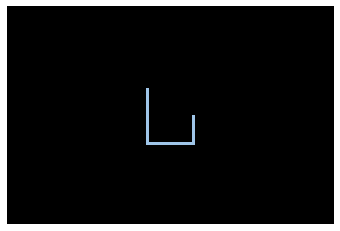

In [104]:
width = 108
height = 72
grid = make_canvas(black, width=width, height=height)
show_map = make_shape(grid, style="fill", shape_array=sprite_array, xalign="center", yalign="center")
grid = draw(grid, show_map, sky_blue)
generate_image(grid, show=True, show_grid=False)

In [ ]:
print(sprite_array)

In [ ]:
image_filepath = "./assets/full-heart.png"
convert_rgb_to_mono(image_filepath, bg_color=0)
sprite_array = convert_sprite_to_array(image_filepath, bg_color=0, scale=1)

In [ ]:
# Sun comes up, sun comes down!
width = 1080
height = 720
sun_radius = 199
sun_max_height = (int(height/2)) - (round(sun_radius/2)) - 50
sun_height_interval = 20
yoffset_vals = np.arange(round(-sun_radius/2), sun_max_height, sun_height_interval)

for yoffset in list(yoffset_vals) + list(yoffset_vals[::-1]):
    grid = make_canvas(black, width=width, height=height)
    show_map = make_shape(grid, style="fill", shape="rectangle", shape_width=1080, shape_height=360, xalign="center", yalign="top")
    grid = draw(grid, show_map, sky_blue)
    show_map = make_shape(grid, style="fill", shape="circle", shape_width=sun_radius, shape_height=sun_radius, xalign="center", yalign="center", yoffset=yoffset)
    grid = draw(grid, show_map, yellow)
    show_map = make_shape(grid, style="fill", shape="rectangle", shape_width=1080, shape_height=360, xalign="center", yalign="bottom")
    grid = draw(grid, show_map, land_green)
    generate_image(grid, show=True, show_grid=False)



In [ ]:
grid = make_canvas(black, width=100, height=100)
show_map = make_shape(grid, style="fill", shape="rectangle", shape_width=1080, shape_height=360, xalign="center", yalign="top")
#grid = draw(grid, show_map, green)
generate_image(grid, show=True, show_grid=False)
#len(np.asarray(image)[14])


In [ ]:
# Simple square
grid = make_canvas(black, width=50, height=50)
show_map = make_shape(grid, style="outline", shape="rectangle", shape_width=31, shape_height=31, xalign="center", yalign="center")
grid = draw(grid, show_map, white)
generate_image(grid, show=True, show_grid=False)

In [ ]:
# Circle with square inside!
grid = make_canvas(black, width=100, height=100)
show_map = make_shape(grid, style="outline", shape="circle", shape_width=75, shape_height=75, xalign="center", yalign="center", xoffset=0, yoffset=0)
grid = draw(grid, show_map, yellow)
show_map = make_shape(grid, shape="rectangle", shape_width=10, shape_height=10, xalign="center", yalign="center", xoffset=0, yoffset=0)
grid = draw(grid, show_map, white)
generate_image(grid, show=True)

In [ ]:
# Pixels of square coming together!
min_steps = 20
max_steps = 20
canvas_width = 20
canvas_height = 20

grid = make_canvas(black, width=canvas_width, height=canvas_height)
seq1 = generate_pixel_sequence(grid, xfinal=9, yfinal=9, min_steps=min_steps, max_steps=max_steps)
seq2 = generate_pixel_sequence(grid, xfinal=10, yfinal=9, min_steps=min_steps, max_steps=max_steps)
seq3 = generate_pixel_sequence(grid, xfinal=9, yfinal=10, min_steps=min_steps, max_steps=max_steps)
seq4 = generate_pixel_sequence(grid, xfinal=10, yfinal=10, min_steps=min_steps, max_steps=max_steps)

for index in range(0, len(seq1)):
    
    grid = make_canvas(black, width=canvas_width, height=canvas_height)
    
    for seq in [seq1, seq2, seq3, seq4]:
        xoffset, yoffset = seq[index]
        show_map = make_shape(grid, white, shape="rectangle", shape_width=1, shape_height=1, xalign="left", yalign="bottom", xoffset=xoffset, yoffset=yoffset)
        grid = draw(grid, show_map, white)
    generate_image(grid, show=False, save=True, outdir="square-assembly", filename=f"{index}.png")
